In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/My Drive/mldata
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive/mldata


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.27421911 0.27090191 0.28156952 0.12027427 0.27122   ]
 [0.26780806 0.27032397 0.28299261 0.09039168 0.27649521]
 [0.25046899 0.253415   0.24191113 0.18775657 0.23038841]
 [0.22074496 0.23118765 0.22093021 0.17453617 0.21427133]] -> [0.23490589]
[[0.27902749 0.2771453  0.29188389 0.08286278 0.28115842]
 [0.27223762 0.27899516 0.28520232 0.08773864 0.2857633 ]
 [0.27421911 0.27090191 0.28156952 0.12027427 0.27122   ]
 [0.26780806 0.27032397 0.28299261 0.09039168 0.27649521]
 [0.25046899 0.253415   0.24191113 0.18775657 0.23038841]
 [0.22074496 0.23118765 0.22093021 0.17453617 0.21427133]
 [0.21678179 0.22942447 0.22459822 0.12722058 0.23490589]] -> [0.21135689]
[[0.27223762 0.27899516 0.28520232 0.08773864 0.2857633 ]
 [0.27421911 0.27090191 0.28156952 0.12027427 0.27122   ]
 [0.26780806 0.27032397 0.28299261 0.09039168 0.27649521]
 [0.25046899 0.253415   0.24191113 0.18775657 0.23038841]
 [0.22074496 0.23118765 0.22093021 0.17453617 0.21427133]
 [

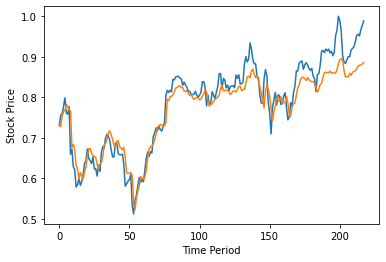

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def normalize(data):
    numerator = data - np.min(data, 0)   # 모든 데이터를 0부터 시작하도록
    denominator = np.max(data, 0) - np.min(data, 0)  #최대값과 최소값 차이 구함
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

tf.set_random_seed(777)  # reproducibility

timesteps = seq_length = 7 #윈도우 크기
data_dim = 5 #Open, High, Low, Volume, Close 
output_dim = 1 

X = tf.placeholder(tf.float32, [None, seq_length, data_dim])  # [None, 7, 5]
Y = tf.placeholder(tf.float32, [None, 1])

# Neural Network Definition -------------------
cell = tf.contrib.rnn.BasicLSTMCell(num_units=output_dim, state_is_tuple=True)  # 1차원 출력
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)  # 5차원 데이터가 7번 입력
hypo = outputs[:, -1]  # 7번 입력하여 나온 7번 출력 중 가장 마지막 것을 신경망의 출력(hypo)으로 사용
# 7묶음 짜리 데이터가 모두 725개, 이만큼 hypo도 만들어짐.

loss = tf.reduce_sum(tf.square(hypo - Y))  # cost/loss function
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])

rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = normalize(xy)
x = xy
y = xy[:, [-1]]  # Extract label

dataX = []
dataY = []
number_of_label = len(y)

# cvs 파일 전체 데이터를 7줄로 구성된 725개의 묶음으로 나누고 724개의 정답
for i in range(0, number_of_label - seq_length): # 725(732 - 7)
    _x = x[i:i + seq_length] # 0~6  (0~725)
    _y = y[i + seq_length]  # The next close price (6~732)
    print(_x, "->", _y) # _x의 한 묶음(7개)가 입력되어 unfolding되면 _y가 되어야 함.
    dataX.append(_x) # 725(732-7)개의 묶음들이  만들어져 들어감
    dataY.append(_y) # 7번 인덱스에 있는 y값부터 하나씩 꺼내어 구성함. 0~6번 인덱스꺼는 무시

# 학습데이터 70%, 테스트 데이터 30%로 분할
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])  # from 0 to train_size - 1
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])  # from train_size to len(dataX) - 1
testY = np.array(dataY[train_size:len(dataY)])

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500): 
    sess.run(train, feed_dict={X: trainX, Y: trainY}) #학습, 경사하강
    step_loss = sess.run(loss, feed_dict={X: trainX, Y: trainY}) #오류는 얼마인지 계산

    print(i, step_loss)

testPredict = sess.run(hypo, feed_dict={X: testX})
print("RMSE", sess.run(rmse, feed_dict={targets: testY, predictions: testPredict}))

# Check the result!
import matplotlib.pyplot as plt
plt.plot(testY)
plt.plot(testPredict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

